In [1]:
import sys
sys.path.insert(0,'python')
from fastRWpkl import *
from scipy import signal
import numpy as np
import scipy
from scipy import signal
from scipy.ndimage.morphology import binary_dilation as bd
import scipy.ndimage as ndimage
from functools import partial
import multiprocessing
import numpy.ma as ma
from collections import Counter

In [56]:
def gaussian(xwin, ywin, xstd, ystd, angle, norm = True):
    win = max(xwin, ywin)
    winx = win*2**0.5
    winy = win*2**0.5
    
    xstd = xstd*2**0.5
    ystd = ystd*2**0.5
        
    xgaus = signal.gaussian(winx, xstd)
    ygaus = signal.gaussian(winy, ystd)
    gaus  = np.outer(xgaus/(xgaus.sum()), ygaus/(ygaus.sum()))
    r_gaus = scipy.ndimage.interpolation.rotate(gaus, angle, reshape=True)
    center = np.array(r_gaus.shape)/2
    cgaus = r_gaus[center[0]-xwin/2.: center[0]+xwin/2., center[1]-ywin/2.:center[1]+ywin/2.]
    if norm:
        return cgaus/cgaus.sum()
    else:
        return cgaus

In [2]:
data = parallel_rw_pkl(None, 'inter_sent%i'%2, 'r')
mask = parallel_rw_pkl(None, 'inter_sentm%i'%2, 'r')
modis_sent = ma.array(data, mask=mask)

In [ ]:
import pylab as plt
%matplotlib inline
plt.imshow(modis_sent[::10,::10])

In [ ]:
plt.imshow(stm[::10,::10])

In [3]:
b4 = parallel_rw_pkl(None, 'band4', 'r')

In [4]:
stm = parallel_rw_pkl(None, 'std_m', 'r')

In [5]:
p_mask = np.unique(stm)

In [6]:
Sent = b4
struct = ndimage.generate_binary_structure(2, 2)

In [7]:
def get_pixels(i):
    sent =  np.zeros_like(Sent)
    mask = (stm==i)  
    brdf = (Counter(modis_sent[mask]).most_common(1)[0][0])*0.001
    xmin = np.where(mask)[0].min()
    xmax = np.where(mask)[0].max()
    ymin = np.where(mask)[1].min()
    ymax = np.where(mask)[1].max()
    indx = np.where(mask)[0]
    indy = np.where(mask)[1]
    dia_mask = bd(mask, structure=struct, iterations=60)
    sent[dia_mask] = Sent[dia_mask]
    to_conv = sent[min(np.where(dia_mask)[0]):max(np.where(dia_mask)[0])+1,
                   min(np.where(dia_mask)[1]):max(np.where(dia_mask)[1])+1]
    mask = mask[xmin:xmax+1, ymin:ymax+1]
    
    return np.array([mask,np.array(to_conv), np.array(brdf), indx, indy], dtype = object)

In [ ]:
'''ite = p_mask[2000:2040]
patches = (get_pixels(k) for k in ite)
par = partial(shift, mode='gaus')
pool = multiprocessing.Pool(processes=45)
data = pool.map(par, patches)
pool.close()
pool.join()
parallel_rw_pkl(data, '2906testgaus', 'w')'''

In [54]:
#Gaussian one
def shift(pat, mode='gaus'): 
    mask,to_conv, brdf, indx, indy = pat
    print mask.sum()
    if (mask.sum() >= 2000) and (mask.sum() < 3000):
        
        if mode == 'mean':
            w = 1./(np.nansum(mask))
            k = np.zeros(mask.shape).astype('float')
            k[mask] = w
            conved = signal.fftconvolve(to_conv, k, mode='valid')
            dif = abs(conved-u)
            minm = np.nanmin(dif)
            x = np.where(dif == minm)[0][0]-np.ceil((conved.shape[0])/2.)
            y = np.where(dif == minm)[1][0]-np.ceil((conved.shape[1])/2.)
            vals = conved[np.where(dif == minm)[0][0], np.where(dif == minm)[1][0]]
            return [x, y , brdf, vals, indx,indy]

        elif mode == 'gaus':
            
            inds = pkl.load(open('pkls/gaus_trans.pkl','rb'))
            vx,vy = pkl.load(open('pkls/gaus_valid.pkl','rb'))
            
            xwin, ywin = 100, 100  
            cost = []
            start = 1.
            star = 0.0001
            end = 60
            for xstd in np.arange(star,end,1):
                for ystd in np.arange(star,end,1):
                    if xstd <=ystd:
                        for angle in xrange(30,160, 2):
                            
                            gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            
                            temp_array = np.zeros((100, 250))
                            temp_array[inds[1], inds[0]] = gaus.ravel()
                            valid  = temp_array[vx,vy]
                
                            nx = vx-vx.min()
                            ny = vy-vy.min()
                            winx = nx.max()+1
                            winy = ny.max()+1
                            kernel = np.zeros((winx,winy))
                            kernel[nx,ny] = valid 
                            
                            if kernel.sum() <= 0:
                                return 0
                            else:
                                ker = kernel/(kernel.sum())
                                conved = signal.fftconvolve(to_conv, ker, mode='valid')
                                dif = abs(conved-brdf)
                                minm = np.nanmin(dif)
                                if minm<start:
                                    x = np.where(dif == minm)[0][0]-np.ceil((conved.shape[0])/2.)
                                    y = np.where(dif == minm)[1][0]-np.ceil((conved.shape[1])/2.)
                                    vals = conved[np.where(dif == minm)[0][0], np.where(dif == minm)[1][0]]
                                    cost.append([xstd, ystd, angle, x, y , brdf, vals, indx, indy])
                                    start = minm
                                    print 'Find One!!', start
                    else:
                        pass
            return cost[-1]           
        else:
            pass   
    else:
        pass

In [43]:
ite = p_mask[2000:2040]
data = [Sent, stm, modis_sent]
patches = get_pixels(ite[35])

In [44]:
x = patches[3]
y = patches[4]

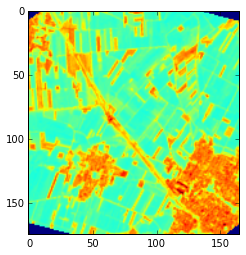

In [45]:
import pylab as plt
%matplotlib inline
plt.imshow(patches[1])

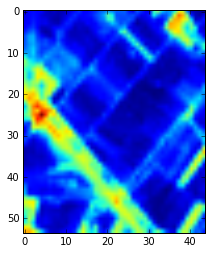

In [46]:
plt.imshow(Sent[x.min():x.max(), y.min():y.max()])

In [47]:
brdf = patches[2]*0.001

In [48]:
mask = patches[0]
to_conv = patches[1]
w = 1./(np.nansum(mask))
k = np.zeros(mask.shape).astype('float')
k[mask] = w

conved = signal.fftconvolve(to_conv, k, mode='valid')

<matplotlib.colorbar.Colorbar instance at 0x7fdf983811b8>

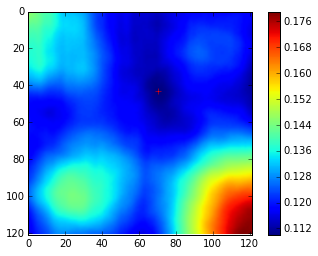

In [49]:
plt.imshow(conved)
minm = conved.min()
x,y = np.where(conved==minm)
plt.plot(y,x, 'r+')
plt.xlim(0,conved.shape[0])
plt.ylim(conved.shape[1],0)
plt.colorbar()

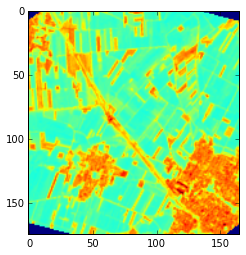

In [50]:
plt.imshow(patches[1])

<matplotlib.colorbar.Colorbar instance at 0x7fdf981cf3b0>

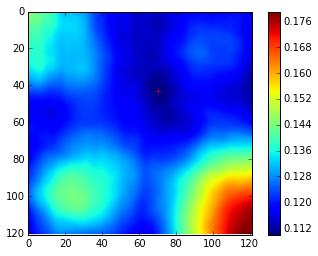

In [51]:
dif = abs(conved-brdf)
plt.imshow(dif)
minm = dif.min()
x,y = np.where(dif==minm)
plt.plot(y,x, 'r+')
plt.xlim(0,dif.shape[0])
plt.ylim(dif.shape[1],0)
plt.colorbar()

In [52]:
center = np.array(dif.shape)/2
x,y = np.where(dif==minm)
shift = center-np.array([x[0],y[0]])
shift

array([ 17, -10])

In [58]:
data = shift(patches, mode = 'gaus')

2087
Find One!! 0.0285747932565
Find One!! 0.0285733917675
Find One!! 0.0285695282127


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in divide
/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


/data/store01/data_dirs/students/ucfafyi/.conda/envs/gdal_env/lib/python2.7/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


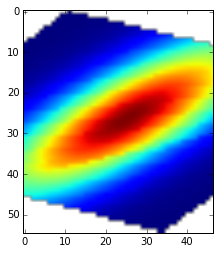

In [68]:
inds = pkl.load(open('pkls/gaus_trans.pkl','rb'))
vx,vy = pkl.load(open('pkls/gaus_valid.pkl','rb'))
xwin, ywin = 100, 100
xstd,ystd = 10, 10
angle = 158
gaus = gaussian(xwin,ywin,xstd,ystd,angle,False)                            
temp_array = np.zeros((100, 250))
temp_array[inds[1], inds[0]] = gaus.ravel()
valid  = temp_array[vx,vy]

nx = vx-vx.min()
ny = vy-vy.min()
winx = nx.max()+1
winy = ny.max()+1
kernel = np.zeros((winx,winy))
kernel[:] = np.nan

kernel[nx,ny] = valid
plt.imshow(kernel)

In [ ]:
ite = p_mask[2000:2040]
patches = (get_pixels(k) for k in ite)
par = partial(shift, mode='gaus')
pool = multiprocessing.Pool(processes=45)
data = pool.map(par, patches)
pool.close()
pool.join()
parallel_rw_pkl(data, '2906testgaus', 'w')